### import 및 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [4]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [5]:
df = pd.read_csv("/content/drive/MyDrive/데이터분석 데브코스/data/pakistan_ecommerce_pre.csv", parse_dates=['created_at'])
df

<ipython-input-5-1536b12b57df>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/데이터분석 데브코스/data/pakistan_ecommerce_pre.csv", parse_dates=['created_at'])


,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category,sales_commission_code,discount_amount,payment_method,bi_status,mv,year,month,customer_since,fy,customer_id
0,211131,complete,2016-07-01,kreations_YI 06-L,1950.0,1,1950.0,100147443,Women's Fashion,\N,0.0,cod,\N,1950.0,2016,7,2016-07,FY17,1.0
1,211133,canceled,2016-07-01,kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Bo...,240.0,1,240.0,100147444,Beauty & Grooming,\N,0.0,cod,Gross,240.0,2016,7,2016-07,FY17,2.0
2,211134,canceled,2016-07-01,Ego_UP0017-999-MR0,2450.0,1,2450.0,100147445,Women's Fashion,\N,0.0,cod,Gross,2450.0,2016,7,2016-07,FY17,3.0
3,211135,complete,2016-07-01,kcc_krone deal,360.0,1,60.0,100147446,Beauty & Grooming,R-FSD-52352,300.0,cod,Net,360.0,2016,7,2016-07,FY17,4.0
4,211136,order_refunded,2016-07-01,BK7010400AG,555.0,2,1110.0,100147447,Soghaat,\N,0.0,cod,Valid,1110.0,2016,7,2016-07,FY17,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584519,905204,cod,2018-08-28,WOFSCE5AE00357AECDE,699.0,1,849.0,100562385,Women's Fashion,\N,0.0,cod,Valid,699.0,2018,8,2018-08,FY19,115320.0
584520,905205,processing,2018-08-28,MATHUA5AF70A7D1E50A,35599.0,1,35899.0,100562386,Mobiles & Tablets,\N,0.0,bankalfalah,Gross,35599.0,2018,8,2018-08,FY19,115326.0
584521,905206,processing,2018-08-28,MATSAM5B6D7208C6D30,129999.0,2,652178.0,100562387,Mobiles & Tablets,\N,0.0,bankalfalah,Gross,259998.0,2018,8,2018-07,FY19,113474.0
584522,905207,processing,2018-08-28,MATSAM5B1509B4696EA,87300.0,2,652178.0,100562387,Mobiles & Tablets,\N,0.0,bankalfalah,Gross,174600.0,2018,8,2018-07,FY19,113474.0


### 데이터 타입 변경 및 그룹핑


In [6]:
# date format 처리

df['customer_since'] = pd.to_datetime(df['customer_since']).dt.to_period('M')

In [7]:
# status 및 payment_method 그룹핑

df['status'].replace(['received','paid','closed'],'complete', inplace=True) # 완료됨
df['status'].replace(['order_refunded'],'refund', inplace=True) # 환불
df['status'].replace(['cod','paid','payment_review','pending','holded','pending_paypal'], 'processing', inplace=True) # 진행중, 결제 안됨
df['status'].replace(['exchange','\\N','fraud'], 'others', inplace=True) # others
# canceled

df['payment_method'].replace(['Payaxis', 'internetbanking','mcblite', 'ublcreditcard', 'bankalfalah'], 'Banks/Cards/Wallets', inplace=True)
df['payment_method'].replace(['easypay_voucher', 'Easypay', 'Easypay_MA'], 'Easypay', inplace=True)
df['payment_method'].replace(['jazzwallet', 'jazzvoucher'], 'JazzCash', inplace=True)
df['payment_method'].replace(['cashatdoorstep', 'cod'], 'Cash on Delivery', inplace=True)
df['payment_method'].replace(['customercredit', 'apg', 'mygateway', 'productcredit','marketingexpense', 'financesettlement'], 'Others', inplace=True)

### 분석에 필요한 데이터 계산

In [8]:
# 하나의 주문에 하나의 데이터(레코드)만 남김
per_order = df.drop_duplicates(subset='increment_id', keep='first')

# 각 고객 당 총 주문 횟수 count
order_cnt = per_order['customer_id'].value_counts().reset_index()

# 일회성 주문 고객(0)인지, 반복 주문 고객(1)인지
order_cnt['re'] = [1 if i>1 else 0 for i in order_cnt['count']]

df = pd.merge(df, order_cnt,on='customer_id')

In [9]:
# 각 레코드가 해당 고객의 몇번째 주문인지
dic = {}
tmp = []
before_id = 0

for i,j in zip(df['customer_id'], df['increment_id']):
  if j == before_id:
    tmp.append(dic[i])
  else:
    if i in dic:
      dic[i]+=1
    else:
      dic[i]=1
    before_id = j
    tmp.append(dic[i])

df['Nth_order'] = tmp

## 분석

### 신규 고객 유입 확인

가설: 블랙프라이데이와 같은 큰 할인 행사 때 주문량이 늘어남과 동시에 신규 고객의 유입이 클 것
</br>
</br>
*우리 나라의 경우 설날, 추석과 같은 명절에 큰 할인 행사가 진행됨

Text(0.5, 1.0, 'monthly new customer count')

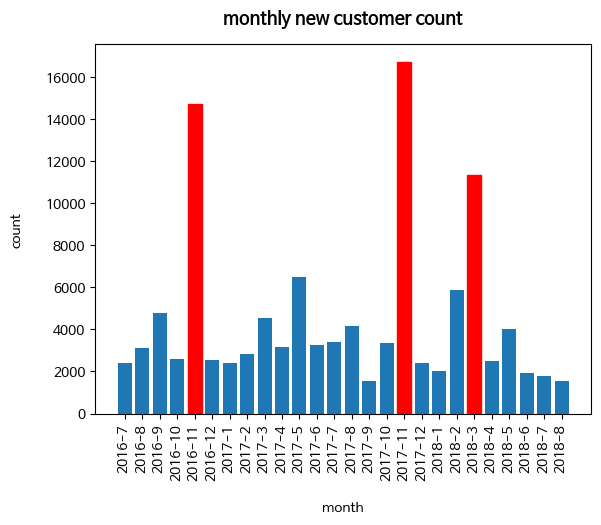

In [10]:
per_order = df.drop_duplicates(subset='increment_id', keep='first')
first_order = per_order[per_order['Nth_order']==1]
newbie_per_month = first_order.groupby(['year','month'])['Nth_order'].count()
tmp_list = []
for i in newbie_per_month.index:
  tmp_list.append(str(i[0])+'-'+str(i[1]))

bars = plt.bar(x=tmp_list, height=newbie_per_month.values)
bars[4].set_color('red')
bars[16].set_color('red')
bars[20].set_color('red')

plt.rc('font', family='NanumBarunGothic')
plt.xticks(rotation=90)
plt.ylabel('count',labelpad=15)
plt.xlabel('month', labelpad=15)
plt.title('monthly new customer count',pad=15, fontweight='bold', fontsize=13)

Text(0.5, 1.0, 'Daily new customer count')

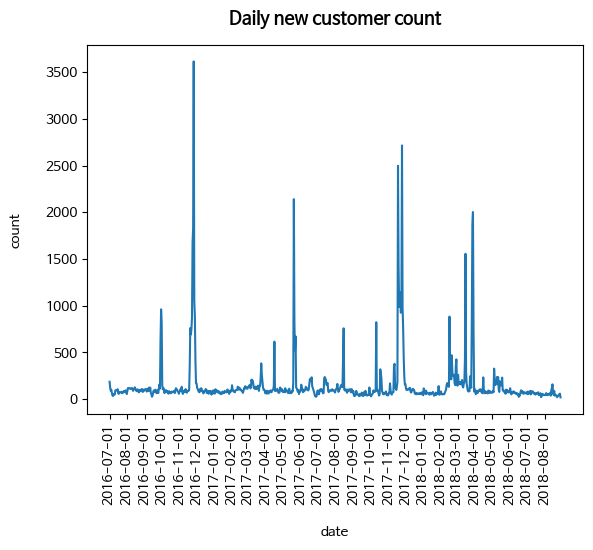

In [11]:
per_order = df.drop_duplicates(subset='increment_id', keep='first')
first_order = per_order[per_order['Nth_order']==1]
newbie_per_date = first_order.groupby(['created_at'])['Nth_order'].count().reset_index()

plt.plot(newbie_per_date['created_at'],newbie_per_date['Nth_order'])

plt.xlabel('date', labelpad=15)
plt.ylabel("count", labelpad=15)
plt.xticks(pd.date_range('2016-07','2018-08', freq='MS').astype(str), rotation=90)
plt.title('Daily new customer count',pad=15, fontweight='bold', fontsize=13)

### 고객 이탈 방지의 중요성

- 고객 수 기준 일회성 구매 고객/반복 구매 고객의 차이 확인
</br>
- 주문 수 기준 일회성 구매 고객/반복 구매 고객 차이 확인

Text(0.5, 1.0, 'Number of customers')

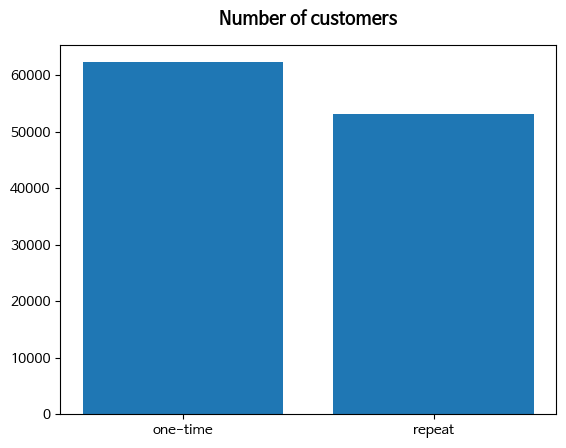

In [12]:
order_cnt = order_cnt['re'].value_counts().reset_index()

plt.bar(x = order_cnt['re'], height=order_cnt['count'])
plt.xlabel('')
plt.xticks([0,1],['one-time','repeat'])
plt.title('Number of customers',pad=15, fontweight='bold', fontsize=13)

Text(0.5, 1.0, 'Number of orders')

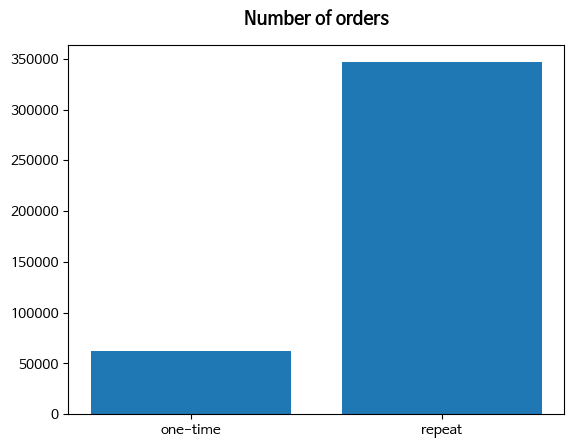

In [13]:
tmp_df = df.drop_duplicates(subset=['increment_id'])
once = len(tmp_df[tmp_df['count']==1])
plt.bar(['one-time','repeat'],[once,len(tmp_df)-once])
plt.title('Number of orders',pad=15, fontweight='bold', fontsize=13)

### 주문 횟수 별 반품 비율 차이

가설: 첫 주문에서 만족감을 얻었을 경우 해당 고객은 재주문을 만들 것이다.
</br>
</br>
반품 여부를 고객의 만족 기준으로 간주 </br>
주문 횟수 별 반품 비율(만족도)을 살펴보고자 함

In [14]:
status_per_Norder = pd.crosstab(index=df['count'],columns=df['status'])[:20]
status_per_Norder['sum'] = status_per_Norder.sum(axis=1)
status_per_Norder['refund_rate'] = status_per_Norder['refund']/status_per_Norder['sum']
status_per_Norder

status,canceled,complete,others,processing,refund,sum,refund_rate
count,,,,,,,
1,18227,53779,2,772,11976,84756,0.141300
2,17314,30218,0,440,7268,55240,0.131571
3,14782,20898,2,244,5166,41092,0.125718
4,14207,21907,1,162,4068,40345,0.100830
5,10862,13824,1,151,2879,27717,0.103871
6,9066,10919,0,118,2278,22381,0.101783
7,7163,9441,0,72,1857,18533,0.100200
8,6829,9289,1,82,1721,17922,0.096027
9,4915,6165,0,77,1183,12340,0.095867


Text(0, 0.5, 'ratio')

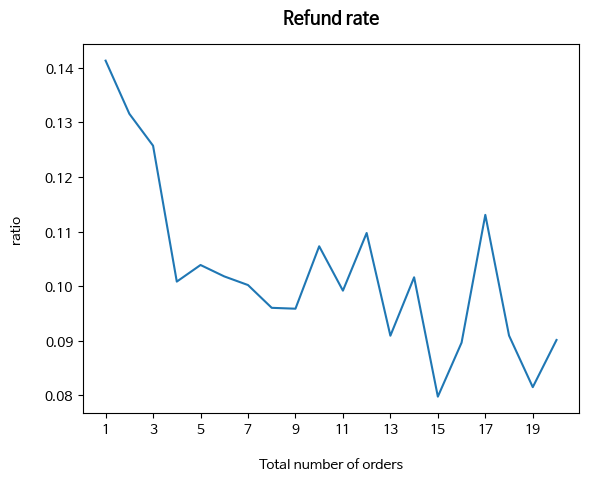

In [15]:
refund_ratio = status_per_Norder['refund_rate'].values

plt.plot(range(1,21),refund_ratio)

plt.title('Refund rate',pad=15, fontweight='bold', fontsize=13)
plt.xticks(range(1,21,2))
plt.xlabel("Total number of orders",labelpad=15) # 고객별 총 주문 횟수
plt.ylabel('ratio',labelpad=15)

### 첫 주문 상품(카테고리)가 주는 만족

가설 1: 첫 주문에서 만족감을 얻었을 경우 해당 고객은 재주문을 만들 것
</br>
가설 2: 재주문을 만든 고객과 그렇지 않은 고객의 첫 주문 상품 카테고리에 차이가 있을 것이라고 생각
</br>
</br>
첫 주문 후 재주문 여부에 따라 두 그룹으로 나눔 (one_time, repeat)
</br>
두 그룹 사이 **첫 주문 상품 카테고리 비율의 차이**를 확인하고자 함

Text(0.5, 1.0, 'Ordered product categories of one-time buyers')

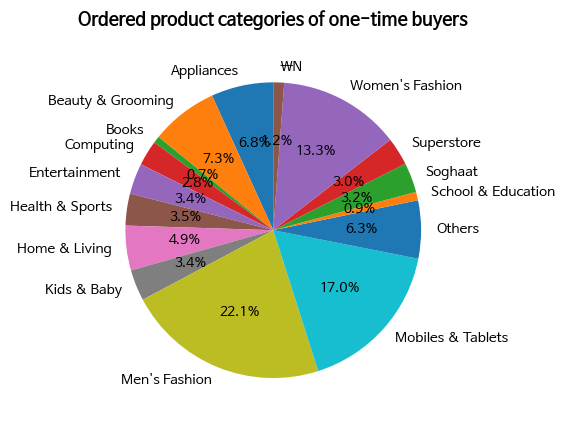

In [16]:
one_time = df[(df['count']==1) & (df['Nth_order']==1)] # 첫 주문으로 그친 고객
f_tmp = one_time['category'].value_counts().reset_index().sort_values(by='category')

plt.pie(f_tmp['count'], labels = f_tmp['category'], autopct='%.1f%%', startangle=90)
plt.title('Ordered product categories of one-time buyers',pad=15, fontweight='bold', fontsize=13)

Text(0.5, 1.0, 'Ordered product categories of repeat buyers')

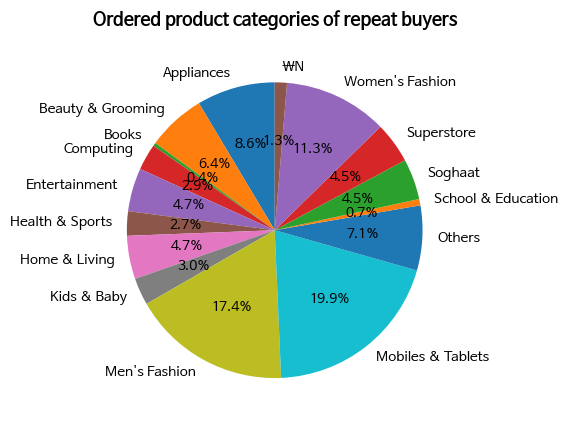

In [17]:
repeat = df[(df['count']!=1) & (df['Nth_order']==1)]
r_tmp = repeat['category'].value_counts().reset_index().sort_values(by='category')

plt.pie(r_tmp['count'], labels = r_tmp['category'], autopct='%.1f%%', startangle=90)
plt.title('Ordered product categories of repeat buyers',pad=15, fontweight='bold', fontsize=13)

### 결제 수단의 편리성

가설: 결제 수단의 불편함으로 고객 이탈이 발생할 수 있다
</br>
</br>
첫 주문 후 재주문 여부에 따라 두 그룹으로 나눔 (one_time, repeat)
</br>두 그룹 사이 **첫 주문에서의 결제 수단 차이**를 살펴봄

In [18]:
one_time = df[(df['count']==1) & (df['Nth_order']==1)]
repeat = df[(df['count']!=1) & (df['Nth_order']==1)]

In [19]:
o_pay = one_time['payment_method'].value_counts().reset_index()
o_pay['rate'] = o_pay['count']/o_pay['count'].sum()
o_pay

,payment_method,count,rate
0,Cash on Delivery,61004,0.719760
1,Easypay,10452,0.123319
2,Banks/Cards/Wallets,9498,0.112063
3,JazzCash,3372,0.039785
4,Others,430,0.005073


In [20]:
r_pay = repeat['payment_method'].value_counts().reset_index()
r_pay['rate'] = r_pay['count']/r_pay['count'].sum()
r_pay

,payment_method,count,rate
0,Cash on Delivery,37785,0.493638
1,Easypay,16735,0.218632
2,Banks/Cards/Wallets,15845,0.207005
3,JazzCash,5426,0.070887
4,Others,753,0.009837


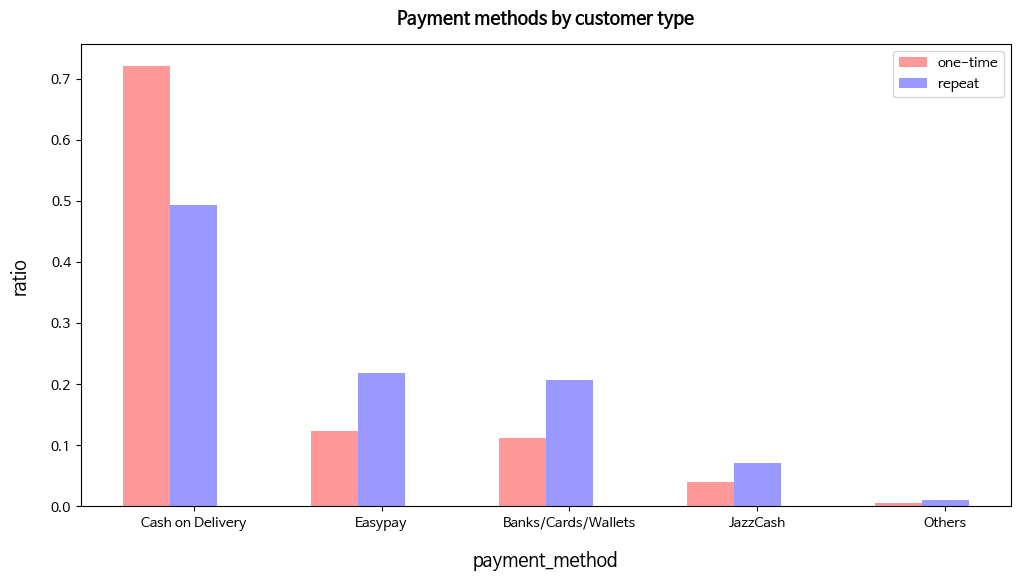

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

index = np.arange(5)

b1 = plt.bar(index, o_pay['rate'], bar_width, alpha=0.4, color='red', label='one-time')
b2 = plt.bar(index + bar_width, r_pay['rate'], bar_width, alpha=0.4, color='blue', label='repeat')
plt.xticks(np.arange(bar_width, 5 + bar_width, 1), r_pay['payment_method'].values)

plt.xlabel('payment_method', size = 13, labelpad=15)
plt.ylabel('ratio', size = 13, labelpad=15)
plt.title("Payment methods by customer type",pad=15, fontweight='bold', fontsize=13)
plt.legend()
plt.show()